# Hourly Time Series Forecasting using Facebook's Prophet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

# Background on the Types of Time Series Data
![img](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# sns.set_theme(style="whitegrid", palette="muted")
# plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.
 
Pulling the `PJM East` which has data from 2002-2018 for the entire east region.
 

In [4]:
pjme = pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


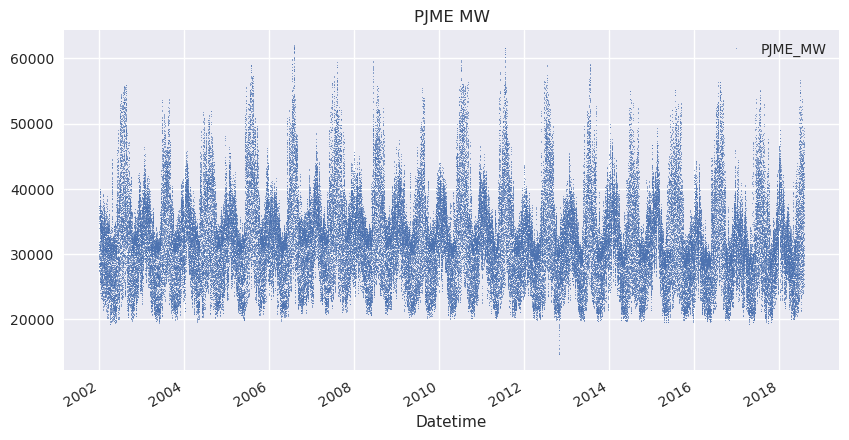

In [5]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [6]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)  # <- fix aquí

    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear','season']]
    if label:
        y = df[label]
        return X, y
    return X


X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [7]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,PJME_MW
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Winter,24860.0
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Winter,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Winter,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Winter,42402.0


In [8]:
features_and_target['weekday'] = features_and_target['dayofweek'].map(
    {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
)


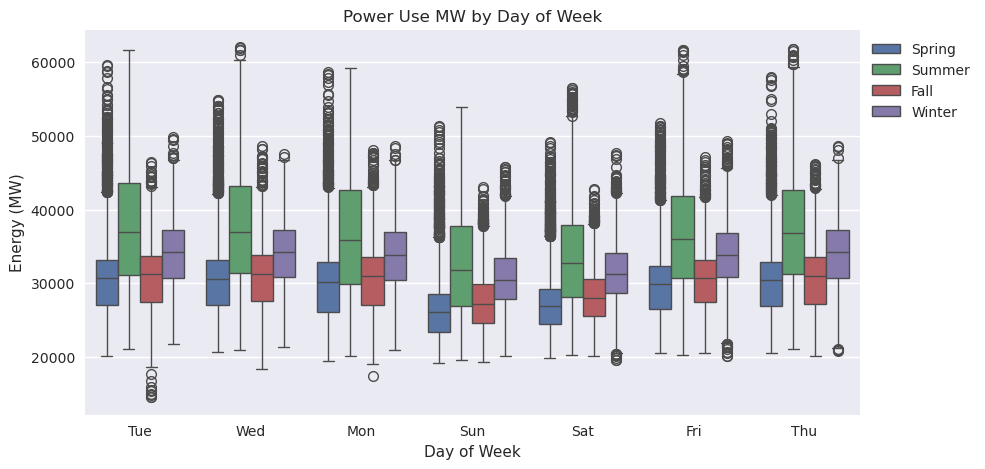

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

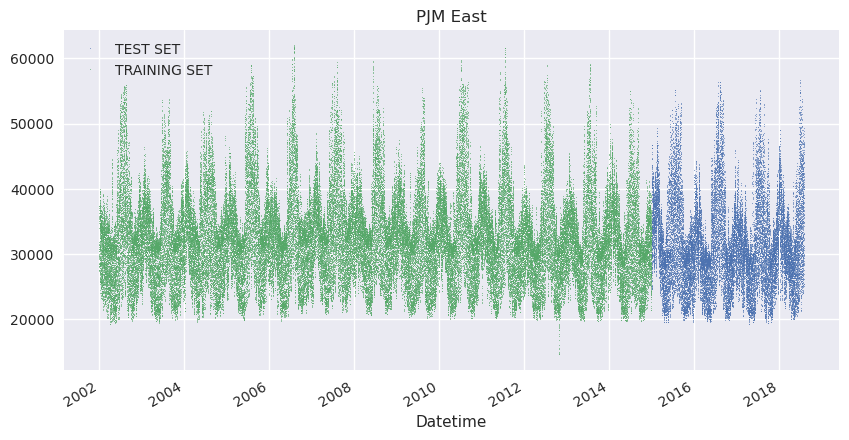

In [10]:
split_date = '1-Jan-2015'
pjme_test = pjme.loc[pjme.index > split_date].copy()
pjme_train = pjme.loc[pjme.index <= split_date].copy()

(
    pjme_test[['PJME_MW']].rename(columns={'PJME_MW': 'TEST SET'})
    .join(
        pjme_train[['PJME_MW']].rename(columns={'PJME_MW': 'TRAINING SET'}),
        how='outer'
    )
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
)
plt.show()


# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [11]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [12]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

12:03:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4.62 s, sys: 696 ms, total: 5.32 s
Wall time: 1min 6s


In [13]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [14]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23849.646193,33135.631309,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22270.999212,31286.019738,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21441.733220,30387.608436,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,20984.785064,30078.624322,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,22009.915147,30826.583811,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


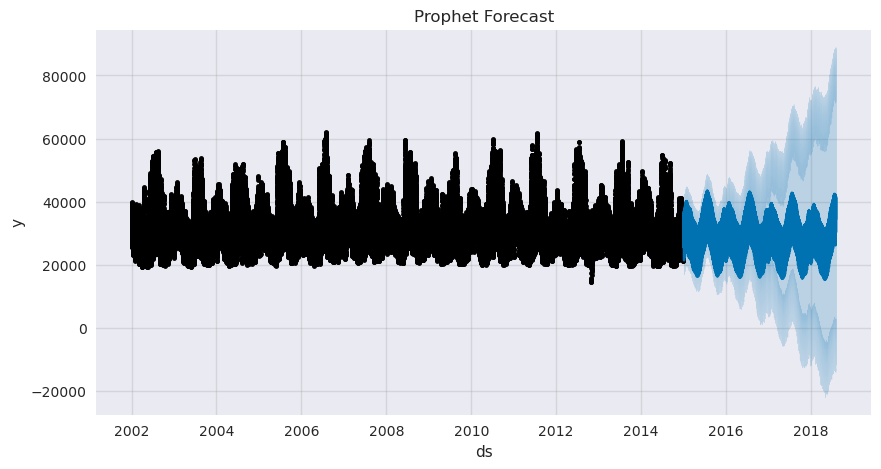

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

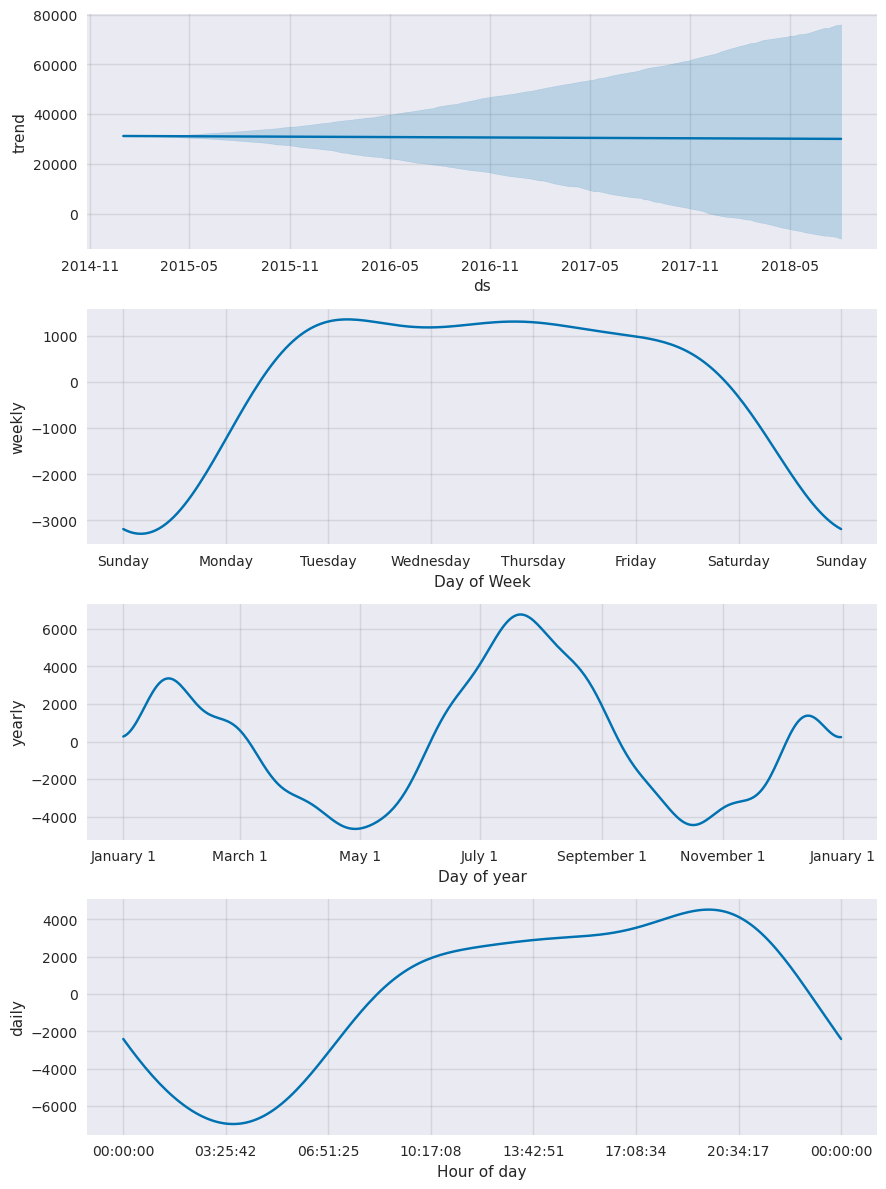

In [16]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

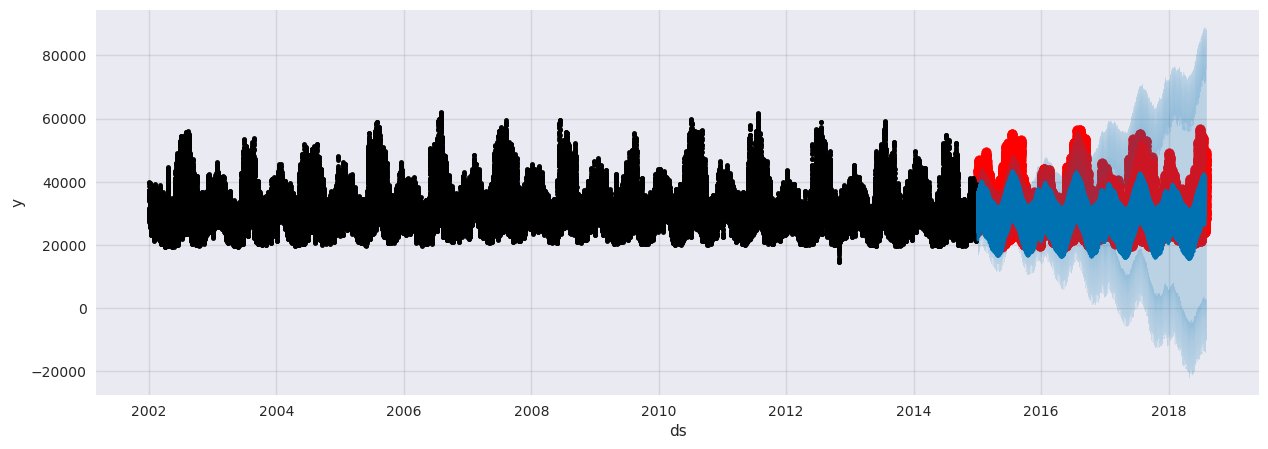

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

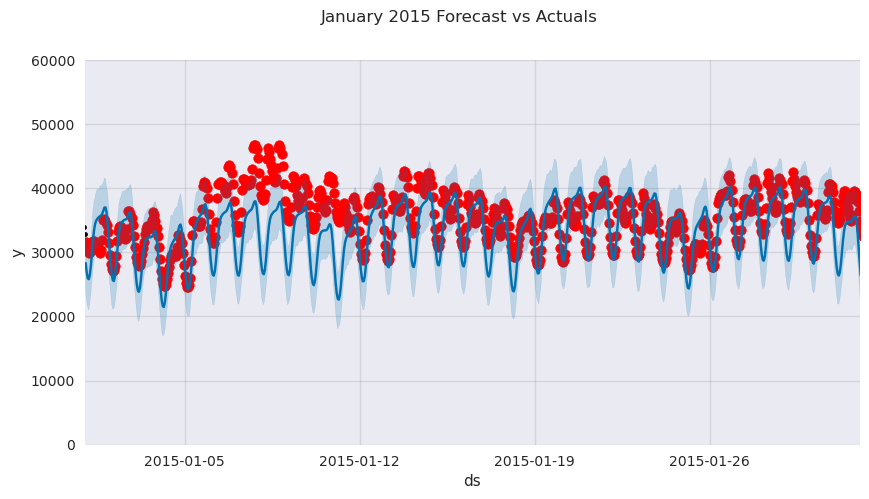

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime("2015-01-01"),
              upper=pd.to_datetime("2015-02-01"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

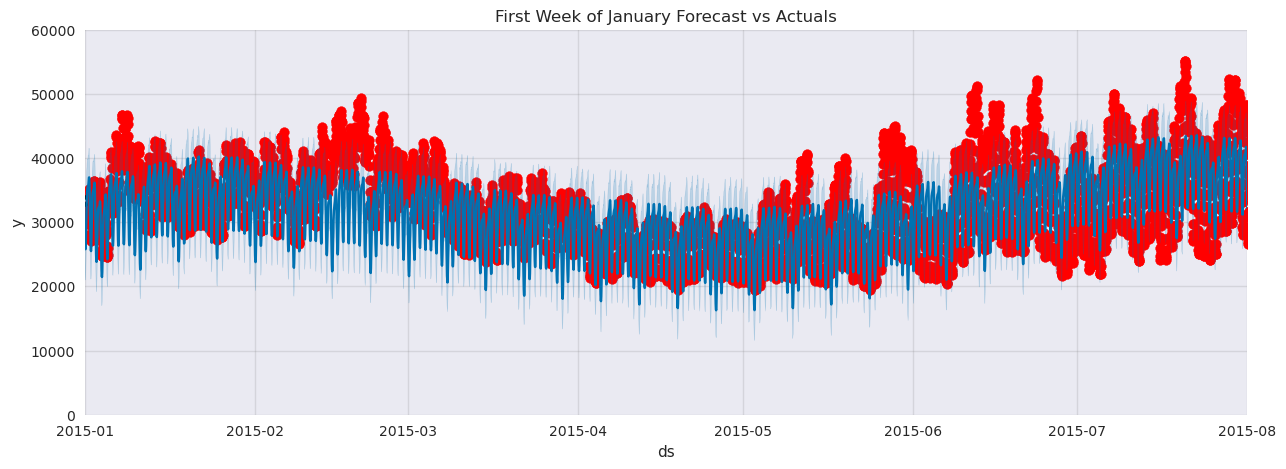

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
#ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_xbound(lower=pd.to_datetime("2015-01-01"),
              upper=pd.to_datetime("2015-08-01"))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics

In [22]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.966074225221

In [23]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [24]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512003880182647

# Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [25]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [26]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 5.45 s, sys: 691 ms, total: 6.14 s
Wall time: 1min 49s


In [27]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

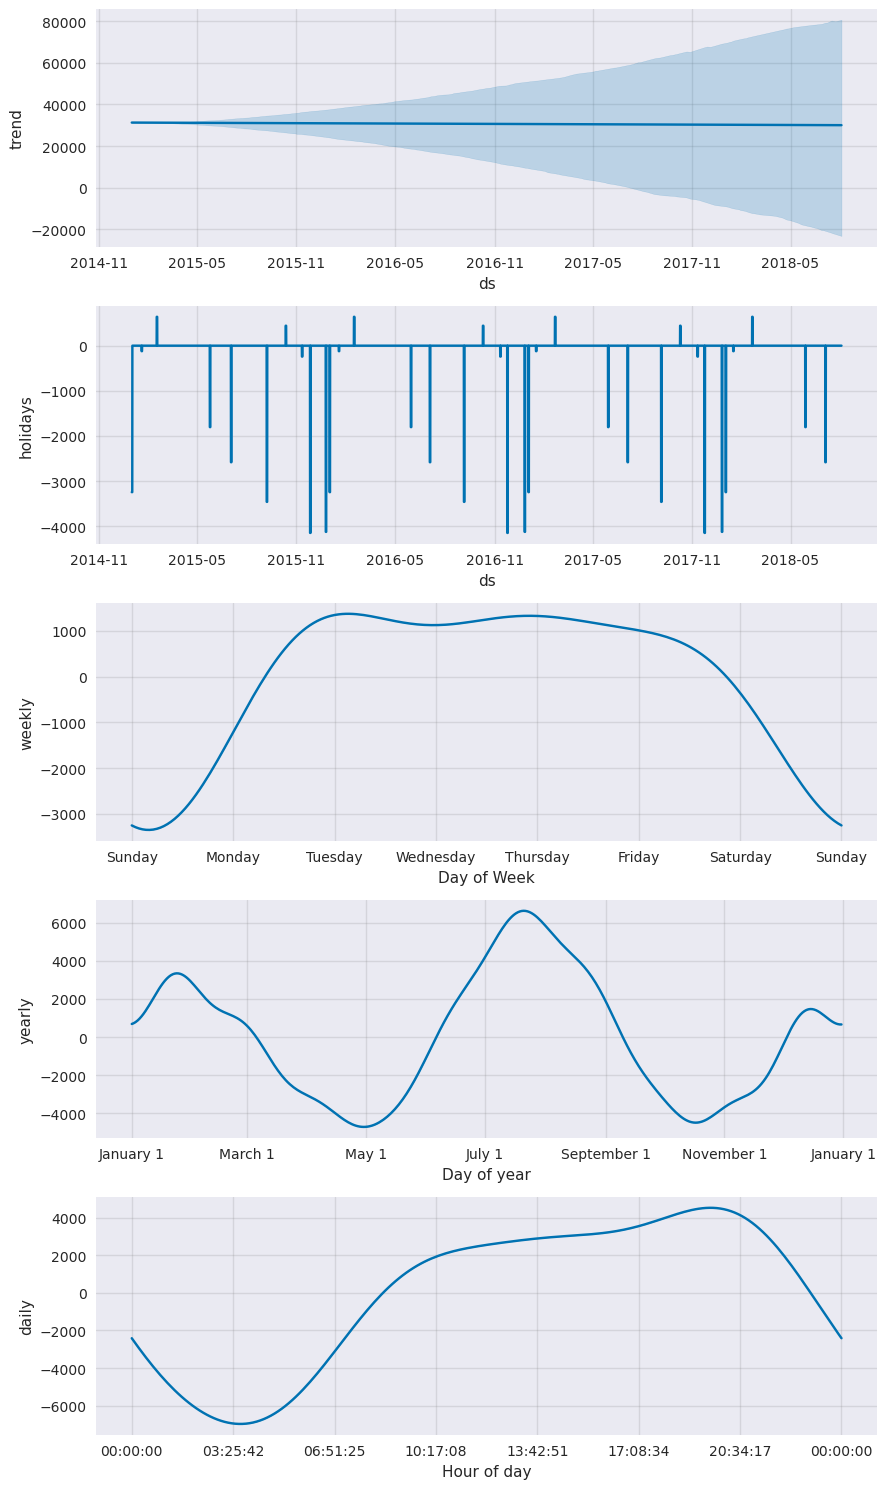

In [28]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

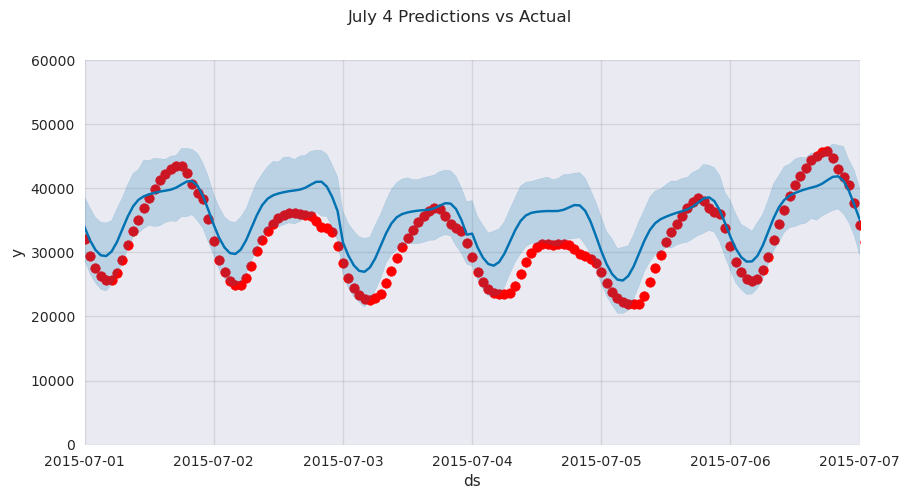

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=pd.to_datetime("2015-07-01"),
              upper=pd.to_datetime("2015-07-07"))
# ax.set_xbound(lower='07-01-2015',
#              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [30]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6639.587205626055

In [31]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5201.46462763833

In [32]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.558807523531467

# Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [33]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [34]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25567.271675
1,2015-01-01 02:00:00,24065.351481
2,2015-01-01 03:00:00,23195.828972
3,2015-01-01 04:00:00,23056.212620
4,2015-01-01 05:00:00,23732.192245


# The End